In [9]:
% setup MRI-education-resources path and requirements
cd ../
startup

loading image
loading signal


# Building Up the MRI Signal Equation

The purpose of this notebook is to build up, with increasing complexity, the MRI signal equation.  For the purposes of learning and understanding many parts of MRI, it is useful to use simplified versions of the MRI signal equation.

## Signal Equation

We can start with the most intimidating version, a full version of signal equation, including relaxation, coil sensitivity, off-resonance and chemical shift, and gradients.

$\vec{r} = [x, y, z]^T$ position in space

$m(\vec{r}) = M_{XY}(\vec{r}, t=0)$ initial transverse magnetization

$C_n(\vec{r})$ receive coil sensitivity profile of the $n$th coil (complex valued)

$T_2^*(\vec{r})$ relaxation rate

$\Delta f_r(\vec{r})$ magnetic field inhomogeneity (macroscopic), including main field imperfections, and magnetic susceptibility effects

$\Delta f_{cs}$ frequency changes due to chemical shift, so depends on the chemical species being examined (could sum or index signal over this dimension)

$\vec{G}(t) = [G_X(t), G_Y(t), G_Z(t)]^T $ magnetic field gradients

$\vec{k}(t) = [k_X(t), k_Y(t), k_Z(t)]^T = \frac{\gamma}{2\pi} \int_0^t \vec{G}(\tau) \cdot \vec{r} d\tau$ k-space trajectory

The signal from an individual RF coil element $n$ is

$$s_n(t) = \int m(\vec{r})\ C_n(\vec{r})\ e^{-t/T_2^*(\vec{r})}\ e^{-i 2 \pi \Delta f_{cs} t} e^{-i 2 \pi \Delta f_r(\vec{r}) t} \  \exp\left( -i \gamma \int_0^t \vec{G}(\tau) \cdot \vec{r} d\tau \right) \  d\vec{r}$$

which is typically simplified for understanding image formation using k-space:

$$s_n(t) = \int m(\vec{r})\ C_n(\vec{r})\ e^{-t/T_2^*(\vec{r})}\ e^{-i 2 \pi \Delta f_{cs} t} e^{-i 2 \pi \Delta f_r(\vec{r}) t} \  e^{-i 2 \pi \vec{k}(t) \cdot \vec{r}} \  d\vec{r}$$

Note that this describes the signal behavior between RF pulses.  Incorporating RF pulses can be done either through rotation matrices or some solution of the Bloch equation. 

## Idealized Signal Equation

In many situations, an idealized signal equation is useful, particularly for understanding image formation.  In the idealized signal equation, we neglect relaxation, RF coil profile, and off-resonance, yielding

$$s(t) = \int m(\vec{r}) \  \exp\left( -i \gamma \int_0^t \vec{G}(\tau) \cdot \vec{r} d\tau \right) \  d\vec{r}$$

Simplified using k-space, we have

$$s(t) = \int m(\vec{r})\  e^{-i 2 \pi \vec{k}(t) \cdot \vec{r}} \  d\vec{r}$$

From this idealized formulation, it is easiest to see that the signal is the Fourier Transform of the object:

$$s(t) = \mathcal{F}\{m(\vec{r}) \} |_{\vec{k} = \vec{k}(t)}$$

Simplified using the notation $M(\vec{k}) = \mathcal{F}\{m(\vec{r}) \}$ as

$$s(t) = M(\vec{k}(t))$$


## Adding Coil Sensitivity

From the idealized signal equation, the RF coil receive profile simply modulates the transverse magnetization, and the received signal for coil element $n$ is

$$s_n(t) = \int m(\vec{r})\ C_n(\vec{r})\ e^{-i 2 \pi \vec{k}(t) \cdot \vec{r}} \  d\vec{r}$$

And the signal is once again the Fourier Transform of the object, but now multiplied by the coil sensitivity:

$$s_n(t) = \mathcal{F}\{m(\vec{r}) \ C_n(\vec{r}) \} |_{\vec{k} = \vec{k}(t)}$$

## Relaxation during signal acquisition

Starting with the idealized signal equation, we can add in relaxation, which modulates the receieved signal over time.  This will create some type of weighting in k-space, which leads to image filtering (often blurring).  This weighting is spatially varying, depending on relaxation of different tissues.

<!-- $$s(t) = \int m(\vec{r}) \ e^{-t/T_2^*(\vec{r})}\  \exp\left( -i \gamma \int_0^t \vec{G}(\tau) \cdot \vec{r} d\tau \right) \  d\vec{r}$$ -->

$$s(t) = \int m(\vec{r})\ e^{-t/T_2^*(\vec{r})}\  e^{-i 2 \pi \vec{k}(t) \cdot \vec{r}} \  d\vec{r}$$

To interpret the effect of relaxation, consider a single value of $T_2^*(\vec{r}) = T_2^*$, in which case this can be removed from the integral and 

$$s(t) = e^{-t/T_2^*} \int m(\vec{r})\ e^{-i 2 \pi \vec{k}(t) \cdot \vec{r}} \  d\vec{r} \\
 = M(\vec{k}(t))\  e^{-t/T_2^*} $$

From this, we can see that relaxation leads to signal amplitude modulation as we acquire data across k-space.  To see the effect on image formation, we determine the function $\upsilon (\vec{k})$ which captures across k-space trajectory in time and across all TRs to characterize this modulation:

$$\hat{M}(\vec{k}) = M(\vec{k}) e^{- \upsilon(\vec{k}) / T_2^*}$$

Examples of $\upsilon(\vec{k})$ are shown below

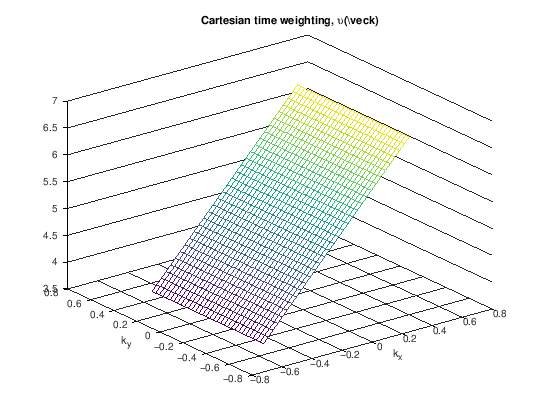

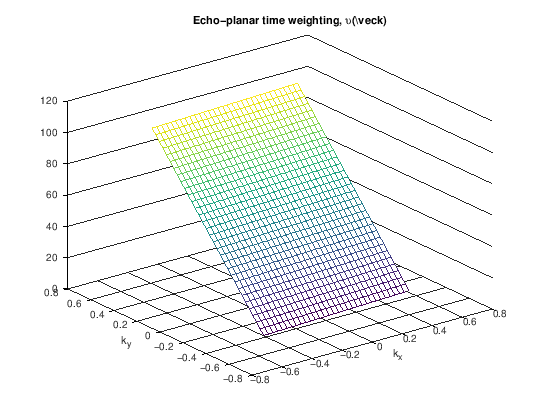

In [14]:
% Example of k-space trajectory time weighting functions, upsilon

% Cartesian

% kx(t)  = gammabar Gxr (t-TE)
% upsilon(k) = t = kx/gamma*Gxr + TE

gamma = 42.58; %kHz/mT
N = 32;
dt = 0.1; % ms
TE = 5; % ms
t = [-N/2+1:N/2]*dt;

Gxr = 1/(N*dt*gamma);

kx0 = gamma*Gxr* t;
[kx ky] = meshgrid(kx0,kx0);

upsilon_Cartesian = kx / (gamma*Gxr) + TE; 

% more simply, upsilon is time to readout single line of k-space
%upsilon = repmat(t + TE, [1 N]);

figure
mesh(kx, ky, upsilon_Cartesian)
xlabel('k_x'), ylabel('k_y')
title('Cartesian time weighting, \upsilon(k)')

% EPI

% add ky weighting as
% ky(t) = tesp * dky
tesp = N*dt; % simplified, assuming no deadtime between ky lines
TE = 5 + tesp*N/2;
% time for all data acquisition
tall = [-N^2/2+1:N^2/2]*dt + TE;

upsilon_EPI = reshape(tall, [N N]).'; 

figure
mesh(kx, ky, upsilon_EPI)
xlabel('k_x'), ylabel('k_y')
title('Echo-planar time weighting, \upsilon(k)')



Thus the reconstructed image will corrupted by a convolution (denoted by $*$) based on the k-space amplitude weighting

$$\hat{m}(\vec{r}) = \mathcal{F}^{-1} \{ \hat{M}(\vec{k})\} = m(\vec{r}) * \mathcal{F}^{-1} \{ e^{-\upsilon(\vec{k})/  T_2^*} \}$$

This convolution can result in blurring (low-pass filtering) for center-out type trajectories, or high-pass filtering (e.g. edge enhancement but overall SNR loss) when starting at the edge of k-space.

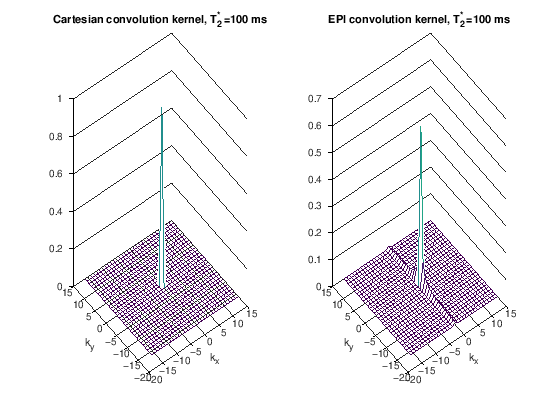

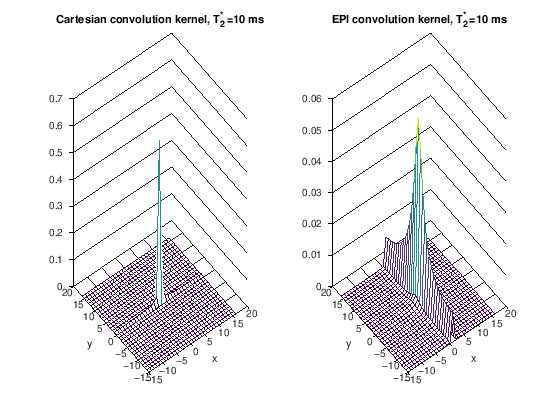

In [19]:
% Convolution kernels for T2* weighting

T2s = 100; % ms

W_Cartesian = ifft2c(exp(-upsilon_Cartesian/T2s));
W_EPI = ifft2c(exp(-upsilon_EPI/T2s));

x0 = [-N/2:N/2-1];
[x y ] = meshgrid(x0,x0);
figure
subplot(121)
mesh(x,y,abs(W_Cartesian))
xlabel('k_x'), ylabel('k_y')
title(['Cartesian convolution kernel, T_2^* =' int2str(T2s) ' ms'])
subplot(122)
mesh(x,y,abs(W_EPI))
xlabel('k_x'), ylabel('k_y')
title(['EPI convolution kernel, T_2^* =' int2str(T2s) ' ms'])

T2s = 10; % ms

W_Cartesian = ifft2c(exp(-upsilon_Cartesian/T2s));
W_EPI = ifft2c(exp(-upsilon_EPI/T2s));

figure
subplot(121)
mesh(x,y,abs(W_Cartesian))
xlabel('x'), ylabel('y')
title(['Cartesian convolution kernel, T_2^* =' int2str(T2s) ' ms'])
subplot(122)
mesh(x,y,abs(W_EPI))
xlabel('x'), ylabel('y')
title(['EPI convolution kernel, T_2^* =' int2str(T2s) ' ms'])

In the above plots, the height of the main peak in the center represents the expected SNR, including losses due to blurring, while the signal amplitude outside of the main peak represents blurring that will occur.   These show that the blurring and signal loss from $T_2^*$ gets worse as the relaxation time is shorter, the blurring it is much worse for EPI (in phase encoding direction) versus Cartesian trajectories. 

## Off-resonance and Chemical Shift

Off-resonance and chemical shift lead to changes in the precession frequency of the magnetization.  We can add this onto the idealized signal equation.
<!-- $$s(t) = \int m(\vec{r})\ e^{-i 2 \pi \Delta f_{cs} t} e^{-i 2 \pi \Delta f_r(\vec{r}) t} e^{-i 2 \pi \vec{k}(t) \cdot \vec{r}} \  d\vec{r}$$ -->
For simplicity, combine all off-resonance and/or chemical shift into a single frequnecy shift term, $\Delta f(\vec{r}) = \Delta f_{cs} + \Delta f_r(\vec{r})$ as

$$s(t) = \int m(\vec{r})\ e^{-i 2 \pi \Delta f(\vec{r}) t} e^{-i 2 \pi \vec{k}(t) \cdot \vec{r}} \  d\vec{r}$$

Solving for the effect of frequency shifts then requires specific knowledge of the k-space trajectory, and the interaction of a spatially varying field further complicates this effect.  However, some intuition can be gained by assuming a single frequency shift, $\Delta f(\vec{r}) = \Delta f_0$, which can then be removed from the integral as

$$s(t) = e^{-i 2 \pi \Delta f_0 t} \int m(\vec{r})\ e^{-i 2 \pi \vec{k}(t) \cdot \vec{r}} \  d\vec{r} \\
 = M(\vec{k}(t))\  e^{-i 2 \pi \Delta f_0 t} $$

From this, we can see that the frequency shift leads to a phase accumulation as we acquire data across k-space.  To see the effect on image formation, we determine the function $\upsilon (\vec{k})$ which captures across k-space trajectory in time and across all TRs to characterize this phase accumulation:

$$\hat{M}(\vec{k}) = M(\vec{k}) e^{-i 2 \pi\ \upsilon(\vec{k}) \Delta f_0}$$

Thus the reconstructed image will corrupted by a convolution based on the k-space phase accumulation

$$\hat{m}(\vec{r}) = \mathcal{F}^{-1} \{ \hat{M}(\vec{k})\} = m(\vec{r}) * \mathcal{F}^{-1} \{ e^{-i 2 \pi\ \upsilon(\vec{k}) \Delta f_0} \}$$

This convolution results in a shift for Cartesian and echo-planar sampling, and blurring for spiral and radial sampling.

This analysis can also be applied to look at the effect from off-resonance at a single location, $\vec{r} = \vec{r}_0$
$$s_{r_0}(t) = \mathcal{F}\{m(\vec{r}_0) \} |_{\vec{k} = \vec{k}(t)}  e^{-i 2 \pi \Delta f(\vec{r}_0) t} $$

$$\hat{m}(\vec{r}_0) = m(\vec{r}_0) \star \mathcal{F}^{-1} \{ e^{-i 2 \pi\ \upsilon(\vec{k}) \Delta f(\vec{r}_0)} \}$$


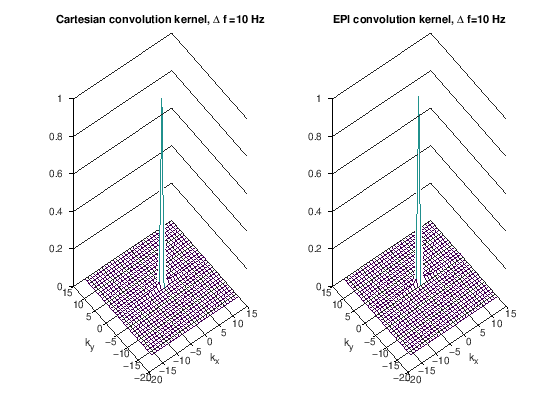

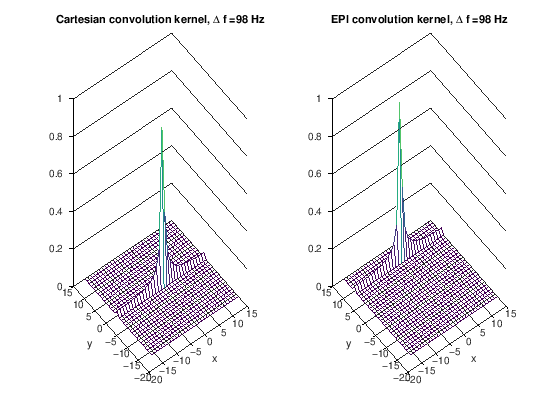

In [21]:
% Convolution kernels for off-resonance weighting

df = 1/(N*tesp); % kHz

W_Cartesian = ifft2c(exp(-i*2*pi*df*upsilon_Cartesian));
W_EPI = ifft2c(exp(-i*2*pi*df*upsilon_EPI));

x0 = [-N/2:N/2-1];
[x y ] = meshgrid(x0,x0);
figure
subplot(121)
mesh(x,y,abs(W_Cartesian))
xlabel('k_x'), ylabel('k_y')
title(['Cartesian convolution kernel, \Delta f =' int2str(df*1e3) ' Hz'])
subplot(122)
mesh(x,y,abs(W_EPI))
xlabel('k_x'), ylabel('k_y')
title(['EPI convolution kernel, \Delta f=' int2str(df*1e3) ' Hz'])

df = 10/(N*tesp); % kHz

W_Cartesian = ifft2c(exp(-i*2*pi*df*upsilon_Cartesian));
W_EPI = ifft2c(exp(-i*2*pi*df*upsilon_EPI));

figure
subplot(121)
mesh(x,y,abs(W_Cartesian))
xlabel('x'), ylabel('y')
title(['Cartesian convolution kernel, \Delta f =' int2str(df*1e3) ' Hz'])
subplot(122)
mesh(x,y,abs(W_EPI))
xlabel('x'), ylabel('y')
title(['EPI convolution kernel, \Delta f =' int2str(df*1e3) ' Hz'])

For frequency shift, the main peak of the convolution kernels is shifted frfom the origin.  This will result in a shift in the reconstructed image.  The shift is much larger for EPI and is in the phase encoding instead of the frequency encoding direction.  (The residual side lobes are due to sinc interpolation effects, similar to Gibbs ringing.)

## K-space Data Weighting

As shown in the relaxation and frequency shift cases above, a powerful framework for characterizing their effects is to define a k-space weighting that determines the signal modulation.  Expressing this generally, define a weighting function
$W(\vec{k})$ that can be complex valued and capture amplitude and phase modulations.  Then, 

$$\hat{M}(\vec{k}) = M(\vec{k}) W(\vec{k}) $$

$$\hat{m}(\vec{r}) = m(\vec{r}) * \mathcal{F}^{-1} \{ W(\vec{k}) \} = m(\vec{r}) * w(\vec{r})$$

Where $w(\vec{r})$ is the inverse Fourier Transform of the weighting function.Thus the effects can be boiled down to a convolution operation in the resulting reconstructed image.

When the frequency shift and relaxation rates vary across space, it is helpful to decompose the image into components, $m_i$ that experience the same weighting (e.g. same frequency shift, or same $T_2^*$) $W_i$.  

$$ m(\vec{r}) = \sum_i m_i(\vec{r}) $$

Since the Fourier Transform is linear, 

$$\hat{M}(\vec{k}) = \sum_i M_i(\vec{k}) W_i(\vec{k}) $$

$$\hat{m}(\vec{r}) =\sum_i m_i(\vec{r}) * w_i(\vec{r})$$

So each component is convolved with its own convolution kernel.  For example, to analyze chemical shift we can divide our image up into water, $m_1(\vec{r})$, and fat, $m_2(\vec{r})$, components, then $W_1(\vec{k}) = 1$, $W_2(\vec{k}) = e^{-i 2 \pi\ \upsilon(\vec{k}) \Delta f_{fat}}$, and the resulting image will be

$$\hat{m}(\vec{r}) = m_1(\vec{r}) + m_2(\vec{r}) * w_2(\vec{r})$$

providing an accurate image of thw water component but some corrupted fat image (typically shifted in space for Cartesian trajectories).


The k-space data weighting concept is very powerful.  It can include frequency shifts. It can include weighting from all types of relaxation ($T_1, T_2, T_2^*$) from more complex acquisition strategies such as SSFP and fast spin-echos.  It can include diffusion-weighting, flow effects, and more